# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 16/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [32]:
# %%capture

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
import datamapplot
import random
from sklearn.metrics.pairwise import cosine_similarity
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
import matplotlib.pyplot as plt



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from preproc.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence,calculate_embedding_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine2 import config
from src.llama_CPP_custom import *

dataset = "DREAMACHINE"
condition = "HS"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")
results_dir = os.path.join(project_root, "EVAL",dataset.lower())
print("Result dir: ",results_dir)

Current working directory: /Users/rb666/Projects/MOSAIC/scripts
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE
Result dir:  /Users/rb666/Projects/MOSAIC/EVAL/dreamachine


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define parameters for current run


In [33]:

sentences = True
random_seed = SEED # uses the global seed 

# # Outlier reduction settings
# reduce_outliers = False
# outlier_strategy = 'embeddings' 
# outlier_threshold = 0.7 #works well with 'embeddings' and 0.7 threshold OR 'probabilities' and 0.15 threshold


### Load and preprocess data


In [34]:

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)


# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports


Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/HS_reflections_APIcleaned.csv


0      Intense chaos. And then my mind checked out an...
1                                            Good stuff.
2      A pattern of red and white lights that flashed...
3      I went back to many hard and mostly beautiful ...
4                                                 Hello.
                             ...                        
328    Changing temperature of my body with the light...
329                                 Pleasure & intrigue.
330                            Travelling through space.
331    I thought a lot about Rand's journey into Rhui...
332    The visual here doesn't look anything like wha...
Name: cleaned_reflection, Length: 333, dtype: object

### Pre-processing


In [35]:
#divide in sentences if needed
if sentences:
    df_reports = split_sentences(df_reports)[0]
print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


#remove sentences defined as too short
min_words = 2 #threshold for minimum words in a sentence
#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")

# Remove duplicate sentences if any
seen = set()
df_reports = [s for s in df_reports if not (s in seen or seen.add(s))]
print(f"After removing duplicates, {len(df_reports)} remain.")


Successfully loaded and processed 736 sentences.
Hello.
Devtest.
Confusion.
Vast.
Immense.
Tessellations.
Hexagons.
Joy.
Starfields.
devtest
l
it
Beautiful!
Thanks!
Euphoria
Unease
Bizarre.
Everything.
Pareidolia.
Soothed.
Tired.
Joy.
Calm
Warm
h
cakm
Anxiety.
l8
Vertigo.
Peace.
Peace.
Sunlight.
True.

There are 33 sentences with less than 2 words.

After removing short sentences, 703 sentences remain.
After removing duplicates, 700 remain.


### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [36]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: Qwen/Qwen3-Embedding-0.6B


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embeddings and vectorizer ready.


### Train BERTopic model 

In [40]:
### Chose either to load best params from grid search, optuna or use defaults tailored ones from the config file

param_selection = "optuna" #can be "optuna", "default", or "grid_search"
target_trial_number = None#65 #or None
sanitized_model_name = config.transformer_model.replace('/', '_') #name of the transformer model with '/' replaced by '_'


if param_selection=="optuna":
    if target_trial_number is None:
        params = pd.read_csv(os.path.join(results_dir,f"optuna_search/OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
        chosen_params = params.iloc[0]
        print("Best parameters loaded from optuna:")
        print(chosen_params)
        # chosen_params_row = params[params['trial_number'] == target_trial_number]
        # # Check if the trial was actually found in the file
        # if not chosen_params_row.empty:
        #     # .iloc[0] selects the first row of the filtered result, which gives us the parameter series
        #     chosen_params = chosen_params_row.iloc[0]
        #     print(f"Parameters successfully loaded for Optuna trial number: {target_trial_number}")
        #     print(chosen_params)
        # else:
        #     raise ValueError(f"Error: Trial number {target_trial_number} was not found in the results file.")

elif param_selection=="grid_search":
    params = pd.read_csv(os.path.join(results_dir,f"GS_results_{condition}_{'sentences' if sentences else ''}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
    chosen_params = params.iloc[0]
    print("Best parameters loaded from grid search:")
    print(chosen_params)
elif param_selection=="default":
    print(f"Loading default parameters for condition: {condition}")
    chosen_params = config.get_default_params(condition)
    print("Default parameters loaded:")
    print(pd.Series(chosen_params))
else:
    raise ValueError("param_selection must be 'optuna', 'default', or 'grid_search'")


Best parameters loaded from optuna:
trial_number             65.000000
embedding_coherence       0.611408
n_components             20.000000
n_neighbors              26.000000
min_dist                  0.015000
min_cluster_size         10.000000
min_samples               8.000000
coherence_score           0.418934
coherence_score_umass   -15.372693
n_topics                 13.000000
Name: 0, dtype: float64


In [41]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    # representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=config.top_n_words, #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step

2025-10-06 16:12:28,954 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-06 16:12:30,527 - BERTopic - Dimensionality - Completed ✓
2025-10-06 16:12:30,529 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-06 16:12:30,570 - BERTopic - Cluster - Completed ✓
2025-10-06 16:12:30,571 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-10-06 16:12:30,599 - BERTopic - Representation - Completed ✓
2025-10-06 16:12:30,600 - BERTopic - Topic reduction - Reducing number of topics
2025-10-06 16:12:30,606 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-06 16:12:30,619 - BERTopic - Representation - Completed ✓
2025-10-06 16:12:30,620 - BERTopic - Topic reduction - Reduced number of topics from 15 to 13


### Check topic and embedding coherence

In [42]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Number of valid topics used for coherence calculation (excludes outliers -1): 12
Initial Word-Based Coherence Score (C_v): 0.4189
Initial Embedding Coherence Score: 0.6114
Initial number of topics extracted: 13
Initial number of outlier sentences: 233


### Add representations (before LLM)

In [43]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

print("\nUpdating model with KeyBERT and MMR representations...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


Updating model with KeyBERT and MMR representations...
Update complete.


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [44]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,233,-1_the_and_it_to,"[the, and, it, to, of, was, in, my, were, but]","[feeling, sensory, feel, thought, then, experi...","[my, were, experience, music, like, felt, time...",[The first time it felt more like it was separ...
1,0,167,0_of_and_saw_shapes,"[of, and, saw, shapes, like, colours, patterns...","[kaleidoscopic, kaleidoscope, kaleidoscopes, c...","[saw, shapes, colours, patterns, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...
2,1,91,1_was_the_felt_my,"[was, the, felt, my, space, and, of, like, thr...","[space, drifted, experiencing, universe, flyin...","[felt, space, like, floating, universe, asleep...","[It felt like my brain was being massaged., I ..."
3,2,46,2_calm_peace_and_relaxation,"[calm, peace, and, relaxation, sense, joy, cal...","[calm, calming, tranquility, relaxing, stillne...","[calm, peace, relaxation, calming, relaxing, m...","[Utter peace and happiness., An incredible sen..."
4,3,31,3_through_journey_speed_moving,"[through, journey, speed, moving, towards, for...","[motion, moving, through, transported, traveli...","[through, journey, speed, moving, portal, trea...","[Journey forward., A varying journey in speed ..."
5,4,25,4_experience_it_amazing_awesome,"[experience, it, amazing, awesome, thank, expe...","[wonderful, experience, amazing, experienced, ...","[experience, amazing, awesome, wonderful, over...","[Fabulous experience., Awesome experience and ..."
6,5,24,5_memories_my_back_felt,"[memories, my, back, felt, like, old, place, w...","[memories, remembered, feeling, remembering, t...","[memories, my, back, old, familiar, house, wom...",[At times it felt like I was back in the womb....
7,6,22,6_felt_relaxed_and_safe,"[felt, relaxed, and, safe, was, sense, peacefu...","[relaxing, relaxation, comforted, relief, comf...","[relaxed, safe, peaceful, euphoria, calm, deep...","[I felt relaxed, safe, and excited at the star..."
8,7,16,7_the_my_me_eyes,"[the, my, me, eyes, light, to, on, of, lights,...","[lights, eyes, light, eye, lighting, flashing,...","[my, eyes, light, lights, flashing, mask, ligh...",[I would have liked a slight diffusion on the ...
9,8,13,8_drugs_perhaps_on_lsd,"[drugs, perhaps, on, lsd, dmt, closest, an, ps...","[hallucinogens, hallucinogenic, psychedelics, ...","[drugs, lsd, dmt, closest, psychedelic, emotio...",[Perhaps even people who want to get off drugs...


In [45]:
docs_info = topic_model.get_document_info(df_reports)
docs_info

,Document,Topic,Name,Representation,KeyBERT,MMR,Representative_Docs,Top_n_words,Probability,Representative_document
0,Intense chaos.,-1,-1_the_and_it_to,"[the, and, it, to, of, was, in, my, were, but]","[feeling, sensory, feel, thought, then, experi...","[my, were, experience, music, like, felt, time...",[The first time it felt more like it was separ...,the - and - it - to - of - was - in - my - wer...,0.050978,False
1,And then my mind checked out and my subconscio...,1,1_was_the_felt_my,"[was, the, felt, my, space, and, of, like, thr...","[space, drifted, experiencing, universe, flyin...","[felt, space, like, floating, universe, asleep...","[It felt like my brain was being massaged., I ...",was - the - felt - my - space - and - of - lik...,0.202541,False
2,What I imagine it's like looking back on life ...,10,10_death_life_like_it,"[death, life, like, it, die, rebirth, you, wha...","[reincarnating, death, dying, rebirth, die, li...","[death, life, die, rebirth, say, retired, dyin...",[The cycle of death and rebirth as envisaged i...,death - life - like - it - die - rebirth - you...,1.000000,False
3,Good stuff.,4,4_experience_it_amazing_awesome,"[experience, it, amazing, awesome, thank, expe...","[wonderful, experience, amazing, experienced, ...","[experience, amazing, awesome, wonderful, over...","[Fabulous experience., Awesome experience and ...",experience - it - amazing - awesome - thank - ...,0.394687,False
4,A pattern of red and white lights that flashed...,0,0_of_and_saw_shapes,"[of, and, saw, shapes, like, colours, patterns...","[kaleidoscopic, kaleidoscope, kaleidoscopes, c...","[saw, shapes, colours, patterns, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...,of - and - saw - shapes - like - colours - pat...,0.432828,False
...,...,...,...,...,...,...,...,...,...,...
695,Pleasure & intrigue.,-1,-1_the_and_it_to,"[the, and, it, to, of, was, in, my, were, but]","[feeling, sensory, feel, thought, then, experi...","[my, were, experience, music, like, felt, time...",[The first time it felt more like it was separ...,the - and - it - to - of - was - in - my - wer...,0.650089,False
696,Travelling through space.,3,3_through_journey_speed_moving,"[through, journey, speed, moving, towards, for...","[motion, moving, through, transported, traveli...","[through, journey, speed, moving, portal, trea...","[Journey forward., A varying journey in speed ...",through - journey - speed - moving - towards -...,0.135155,False
697,I thought a lot about Rand's journey into Rhui...,1,1_was_the_felt_my,"[was, the, felt, my, space, and, of, like, thr...","[space, drifted, experiencing, universe, flyin...","[felt, space, like, floating, universe, asleep...","[It felt like my brain was being massaged., I ...",was - the - felt - my - space - and - of - lik...,0.149363,False
698,The visual here doesn't look anything like wha...,-1,-1_the_and_it_to,"[the, and, it, to, of, was, in, my, were, but]","[feeling, sensory, feel, thought, then, experi...","[my, were, experience, music, like, felt, time...",[The first time it felt more like it was separ...,the - and - it - to - of - was - in - my - wer...,0.061783,False


In [47]:
topic_id = 1 #check this topic content

print(f"Representative sentences for topic {topic_id}: ",topic_model.get_representative_docs(topic_id)) #get representative documents for topic 1

all_sentences_topic = [doc for doc, topic in zip(df_reports, topics) if topic == topic_id] #get all sentences assigned to topic 1
print(f"\nNumber of documents assigned to topic {topic_id}: {len(all_sentences_topic)}\n")
for doc in all_sentences_topic:
    print(doc)


docs_info= topic_model.get_document_info(df_reports)
topic_docs = docs_info[docs_info['Topic'] == topic_id]
topic_docs_sorted = topic_docs.sort_values(by='Probability', ascending=False)#.reset_index(drop=True)


topic_docs_sorted = topic_docs_sorted.rename(columns={
    'Document': 'Sentence',
    'Probability': 'Topic_Probability'
})

result_table = topic_docs_sorted[['Sentence', 'Topic_Probability','Representative_document']]

print(result_table)

# result_table.to_csv(f'../RESULTS/dreamachine/topics_content/topic{topic_id}.csv')

Representative sentences for topic 1:  ['It felt like my brain was being massaged.', 'I felt like I was on a journey through space riding in a kaleidoscope... it was an out-of-body experience on occasion, and I felt a spinning sensation and like I could see galaxies and star clusters all around my invisible kaleidospacescraft.', 'Felt out of my body—in fact, off planet Earth—like I took a trip into space']

Number of documents assigned to topic 1: 91

And then my mind checked out and my subconscious took over and started talking.
I also felt asleep for a bit and I was thinking of my partner, who I could visualize.
Dreaming while awake—flashes of random places I have been.
I dreamt myself as a harbinger of the new planet, shaping the world with life and equity.
My eyes wouldn't stop watering, so that kept my mind occupied.
It was as if I was moving through a portal through time and space.
I also felt like seeing the origin of our galaxy and trying to understand the meaning of life.
I wa

### Experiment with Vectorizer Settings (without re-training)
use the `.update_topics()` function to quickly test different `CountVectorizer` settings and see how they change the keywords (without re-running the clustering)


In [48]:
# --- First, let's see the keywords from your initial model run for comparison ---
print("--- Initial Keywords (from loaded GS parameters) ---")
# Let's look at the first 4 topics as an example
num_topics = len(topic_model.get_topic_info()) - 1 
for topic_id in range(num_topics):
    # The .get_topic() method returns a list of (word, score) tuples
    keywords = [word for word, score in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {keywords}")
print("\n" + "="*80 + "\n")

--- Initial Keywords (from loaded GS parameters) ---
Topic 0: ['of', 'and', 'saw', 'shapes', 'like', 'colours', 'patterns', 'the', 'in', 'kaleidoscope']
Topic 1: ['was', 'the', 'felt', 'my', 'space', 'and', 'of', 'like', 'through', 'as']
Topic 2: ['calm', 'peace', 'and', 'relaxation', 'sense', 'joy', 'calming', 'great', 'relaxing', 'music']
Topic 3: ['through', 'journey', 'speed', 'moving', 'towards', 'forward', 'portal', 'sense', 'fast', 'away']
Topic 4: ['experience', 'it', 'amazing', 'awesome', 'thank', 'expected', 'wonderful', 'overall', 'very', 'good']
Topic 5: ['memories', 'my', 'back', 'felt', 'like', 'old', 'place', 'was', 'and', 'in']
Topic 6: ['felt', 'relaxed', 'and', 'safe', 'was', 'sense', 'peaceful', 'euphoria', 'also', 'it']
Topic 7: ['the', 'my', 'me', 'eyes', 'light', 'to', 'on', 'of', 'lights', 'made']
Topic 8: ['drugs', 'perhaps', 'on', 'lsd', 'dmt', 'closest', 'an', 'psychedelic', 'the', 'having']
Topic 9: ['too', 'was', 'it', 'how', 'way', 'feeling', 'sometimes', '

### Reduce outliers

In [49]:
#print the sentences that have been considered outliers
outlier_sentences = [doc for doc, topic in zip(df_reports, topics) if topic == -1]
print(f"N={len(outlier_sentences)} outlier sentences:")
for sentence in outlier_sentences:
    print(sentence)

N=233 outlier sentences:
Intense chaos.
I tended to shift between focusing on the sound or the colors.
Sound inside my body.
The louder the music, the better.
I couldn't help thinking what would happen with a drum beat, maybe allow some non-Euro music in, much as I love John Hopkins.
The vastness was just poetic and beautiful.
Feeling of things coming at you.
The sensory is overwhelming and powerful.
I was scared at first but calmed down after a while.
It feels like a symbolism of acceptance of self, my own fear, and life.
Dream Machine is an unforgettable, magical, and life-affirming experience.
I didn't feel in control and wondered how this would be positive.
But then I found I could shut it out if I wanted and was able to relax—almost falling asleep at times.
Good beats leading me on.
Felt similar to being in an MRI machine.
And a sense of really being inside my head.
One was the ocean; another, a house in grass fields near cliffs next to the ocean; another, I was approaching Heaven

In [50]:

# Store the original topics before the loop
original_topics = topic_model.topics_

# --- Define strategies and thresholds to test ---
strategies = ['probabilities', 'embeddings']
thresholds_to_test = {
    'probabilities': np.arange(0.1, 0.51, 0.05), #explore between 0.1 and 0.50 
    'embeddings': np.arange(0.5, 0.81, 0.05)
}

results = []

# --- Iterate over each strategy and threshold ---
for strategy in strategies:
    for threshold in thresholds_to_test[strategy]:
        print(f"Testing strategy '{strategy}' with threshold {threshold:.2f}...")
        
        # NOTE: The reduce_outliers function checks the internal state of `topic_model` before running.
        # This is why the model must be reset at the end of each iteration.
        new_topics = topic_model.reduce_outliers(
            df_reports, 
            topics, # It is safe to use the original `topics` variable here
            strategy=strategy,
            probabilities=probs,
            embeddings=embeddings,
            threshold=threshold
        )
        
        # Temporarily update the model to calculate coherence with new topics
        topic_model.update_topics(df_reports, topics=new_topics)
        
        # Calculate metrics
        num_outliers = len([t for t in new_topics if t == -1])
        cv_coherence, _ = calculate_coherence(topic_model, df_reports)
        emb_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)

        # Store results
        results.append({
            'Strategy': strategy,
            'Threshold': threshold,
            'Num_Outliers': num_outliers,
            'Cv_Coherence': cv_coherence,
            'Embedding_Coherence': emb_coherence
        })
        
        # THIS IS THE CRITICAL FIX: Reset the model to its original state before the next iteration
        topic_model.update_topics(df_reports, topics=original_topics)

# --- Create and display the results DataFrame ---
results_df = pd.DataFrame(results)
print("\n--- Evaluation Complete ---")
display(results_df)

2025-10-06 16:13:08,526 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Testing strategy 'probabilities' with threshold 0.10...


2025-10-06 16:13:11,604 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:11,635 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.15...


2025-10-06 16:13:14,298 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:14,316 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.20...


2025-10-06 16:13:16,936 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:16,951 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.25...


2025-10-06 16:13:19,660 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:19,691 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.30...


2025-10-06 16:13:22,361 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:22,394 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.35...


2025-10-06 16:13:25,076 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:25,091 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.40...


2025-10-06 16:13:27,714 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:27,726 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.45...


2025-10-06 16:13:30,355 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:30,392 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'probabilities' with threshold 0.50...


2025-10-06 16:13:33,049 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:33,075 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.50...


2025-10-06 16:13:35,704 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:35,728 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.55...


2025-10-06 16:13:38,437 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:38,468 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.60...


2025-10-06 16:13:41,054 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:41,090 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.65...


2025-10-06 16:13:43,711 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:43,728 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.70...


2025-10-06 16:13:46,302 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:46,326 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.75...


2025-10-06 16:13:48,977 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-10-06 16:13:49,003 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12
Testing strategy 'embeddings' with threshold 0.80...


2025-10-06 16:13:51,627 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 12

--- Evaluation Complete ---


,Strategy,Threshold,Num_Outliers,Cv_Coherence,Embedding_Coherence
0,probabilities,0.10,97,0.419598,0.576488
1,probabilities,0.15,136,0.421752,0.587335
2,probabilities,0.20,183,0.413757,0.597648
3,probabilities,0.25,204,0.413388,0.605367
4,probabilities,0.30,223,0.408109,0.610576
5,probabilities,0.35,228,0.405801,0.609957
6,probabilities,0.40,232,0.405801,0.610398
7,probabilities,0.45,233,0.399816,0.611408
8,probabilities,0.50,233,0.399816,0.611408
9,embeddings,0.50,4,0.419131,0.570541


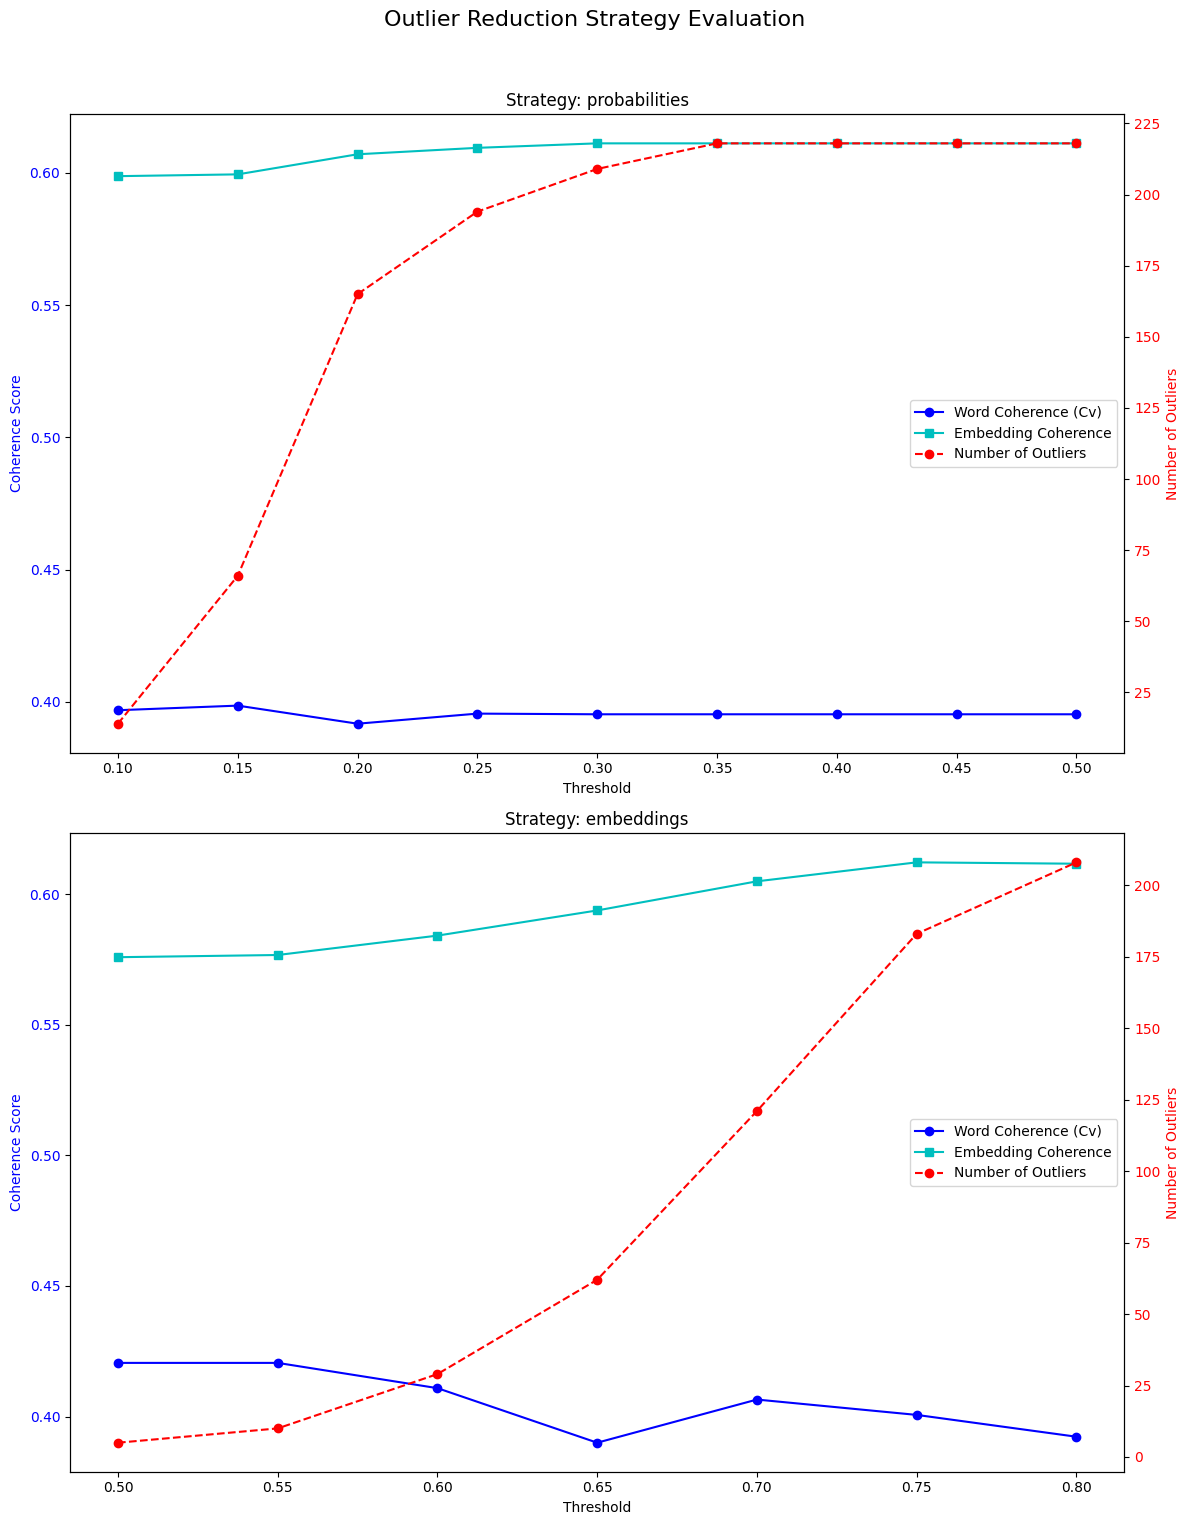

In [16]:
# --- Create plots to visualise the results ---
fig, axes = plt.subplots(len(strategies), 1, figsize=(12, 8 * len(strategies)))
fig.suptitle('Outlier Reduction Strategy Evaluation', fontsize=16)

for i, strategy in enumerate(strategies):
    ax = axes[i]
    strategy_df = results_df[results_df['Strategy'] == strategy]
    
    # Plot coherence scores on the primary y-axis
    ax.plot(strategy_df['Threshold'], strategy_df['Cv_Coherence'], 'o-', color='b', label='Word Coherence (Cv)')
    ax.plot(strategy_df['Threshold'], strategy_df['Embedding_Coherence'], 's-', color='c', label='Embedding Coherence')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Coherence Score', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_title(f'Strategy: {strategy}')
    
    # Create a secondary y-axis for the number of outliers
    ax2 = ax.twinx()
    ax2.plot(strategy_df['Threshold'], strategy_df['Num_Outliers'], 'o--', color='r', label='Number of Outliers')
    ax2.set_ylabel('Number of Outliers', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [17]:
# reduce outliers (optional)
# outlier_strategy = 'embeddings' 
# outlier_threshold = 0.65
outlier_strategy = 'probabilities' 
outlier_threshold = 0.15


reduce_outliers = True

if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")
    embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
    print(f"Embedding Coherence Score after outlier reduction: {embedding_coherence:.4f}") # Display the new score
    print(f"Number of topics after outlier reduction: {len(np.unique(topics))}\n")

2025-10-03 14:21:57,277 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Reducing outliers using the 'probabilities' strategy with threshold 0.15...
Remaining outliers after reduction: 66
Number of valid topics used for coherence calculation (excludes outliers -1): 11
Coherence Score after outlier reduction: 0.398601828340271
Embedding Coherence Score after outlier reduction: 0.5995
Number of topics after outlier reduction: 12



In [18]:
topic_model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [19]:
topic_model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

In [20]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    ctfidf_keywords = row['Representation']
    keybert_keywords = row['KeyBERT']
    mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - c-TF-IDF: {ctfidf_keywords}")
    print(f"  - KeyBERT: {keybert_keywords}")
    print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---

Topic 0:
  - c-TF-IDF: ['of', 'and', 'the', 'saw', 'in', 'like', 'was', 'to', 'through', 'at']
  - KeyBERT: ['kaleidoscopic', 'kaleidoscope', 'colourful', 'colours', 'colors', 'sky', 'shapes', 'colour', 'blue', 'shape']
  - MMR:     ['saw', 'like', 'shapes', 'colours', 'patterns', 'blue', 'kaleidoscope', 'stars', 'moving', 'geometric']

Topic 1:
  - c-TF-IDF: ['it', 'was', 'to', 'and', 'the', 'my', 'felt', 'experience', 'of', 'but']
  - KeyBERT: ['feeling', 'memories', 'remembered', 'emotions', 'sensation', 'felt', 'feel', 'my', 'there', 'experiences']
  - MMR:     ['felt', 'experience', 'memories', 'feeling', 'back', 'old', 'place', 'sense', 'strong', 'really']

Topic 2:
  - c-TF-IDF: ['calm', 'peace', 'and', 'relaxation', 'sense', 'joy', 'relaxing', 'music', 'peaceful', 'tranquility']
  - KeyBERT: ['calm', 'calming', 'tranquility', 'relaxing', 'stillness', 'serenity', 'relaxation', 'peaceful', 'peace', 'peacefulness']
 

# Update model with LLAMA 3 for Topic Labelling

In [21]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n","Label:","Topic name:","Keywords:","(Note:","Note:","The label is:"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64  

In [22]:

    
pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.2,
    "repeat_penalty": 1.2
}

prompt = """Below are documents and keywords that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]


TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""


prompt_custom = """Below are sentences and keyword sets that describe a single topic.

SENTENCES:
[SENTENCES]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]

TASK:
Uses information from the SENTENCES and the KEYWORDS to generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise but precise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""



# Instantiate our new custom model
llm_model = LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)
llm_model_custom = PhenoLabeler(llm, prompt=prompt_custom,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3,verbose=False) #set verbose to True to see which sentences and keywords have been used as LLM input
lll_model_custom2 = MultiKeywordLLM(llm, prompt=prompt_custom, pipeline_kwargs=pipeline_kwargs,nr_docs=10)

# Define the representation model using our custom class
representation_model = {"LLM": llm_model,"LLM_Custom": llm_model_custom,"LLM_Custom2": lll_model_custom2}

# UPDATE THE FITTED MODEL - this now works as you originally wanted
print("Updating topic representations with custom Llama 3 prompter...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")

#now check our new generatd labels
topic_model.get_topic_info()

Updating topic representations with custom Llama 3 prompter...


100%|██████████| 12/12 [00:18<00:00,  1.54s/it]


Update complete.


,Topic,Count,Name,Representation,KeyBERT,MMR,LLM,LLM_Custom,LLM_Custom2,Representative_Docs
0,-1,66,-1_the_it_music_and,"[the, it, music, and, to, would, of, my, an, w...","[feeling, thought, feel, then, my, this, felt,...","[my, were, music, like, experience, felt, time...","[Brainwave Entrainment and Sensory Experience,...",[Subjective Experience of Sound and Visual Sti...,NaN,[A totally immersive experience; it felt like ...
1,0,297,0_of_and_the_saw,"[of, and, the, saw, in, like, was, to, through...","[kaleidoscopic, kaleidoscope, colourful, colou...","[saw, like, shapes, colours, patterns, blue, k...",[Visual Perception of Cosmic and Microcosmic P...,[Vivid Visual Experience of Cosmic Patterns an...,Kaleidoscopic Colour Patterns in the Sky\n```\...,[I saw many kinds of patterns from sparks to g...
2,1,133,1_it_was_to_and,"[it, was, to, and, the, my, felt, experience, ...","[feeling, memories, remembered, emotions, sens...","[felt, experience, memories, feeling, back, ol...",[Subjective Experience of Altered States and M...,"[Subjective Experience of Sensory Deprivation,...",```\n\nThe task is to generate a scientific la...,[At times it felt like I was back in the womb....
3,2,42,2_calm_peace_and_relaxation,"[calm, peace, and, relaxation, sense, joy, rel...","[calm, calming, tranquility, relaxing, stillne...","[calm, peace, relaxation, relaxing, music, pea...","[Meditative Music and Light Experience, , , , ...",[Experiential State of Deep Relaxation and Pea...,Relaxation and Peacefulness\n```\n\nThe task i...,"[Peace and contentment., Utter peace and happi..."
4,3,32,3_journey_through_towards_forward,"[journey, through, towards, forward, moving, t...","[journey, through, moving, motion, towards, tr...","[journey, through, moving, speed, highway, que...",[Perceptual Experience of Time and Space Trave...,"[Time-Space Travel and Expansion Phenomena, , ...",```\n\nThe output of this task is a single sci...,"[A portal moving towards me, away from me, thr..."
5,4,28,4_experience_very_it_good,"[experience, very, it, good, interesting, amaz...","[wonderful, experience, amazing, experienced, ...","[experience, amazing, wonderful, overall, good...",[Positive Personal Experience with Unmet Expec...,"[Positive and Unpredictable Life Experience, ,...",wonderful experience with very good results\n`...,"[Fabulous experience., Thanks for the experien..."
6,5,28,5_felt_and_relaxed_was,"[felt, and, relaxed, was, safe, also, of, sens...","[relaxation, relax, sensations, comforted, rel...","[relaxed, safe, peaceful, euphoria, relaxation...",[Meditative Experience of Euphoria and Deep Re...,[Meditative Experience of Deep Relaxation and ...,Relaxation and Comfort\n```\n\nHere is the out...,"[I felt relaxed, safe, and excited at the star..."
7,6,18,6_asleep_quite_dreamlike_had,"[asleep, quite, dreamlike, had, dreaming, drif...","[semiconscious, dreaming, dreamlike, asleep, d...","[asleep, dreamlike, dreaming, consciousness, d...","[Lucid Dreaming and Hypnagogic States, , , , ,...",[Dream-Like State and Its Relationship to Slee...,semiconscious dreaming state\n```\n\nThis task...,[I did not have profound thoughts during the e...
8,7,22,7_the_on_to_my,"[the, on, to, my, me, eyes, focused, light, of...","[lights, light, eyes, eye, intensity, lighting...","[eyes, light, lights, intensity, flashing, mas...",[Perceptual Effects of Flashing Light Intensit...,[Subjective Experience of Flashing Light Inten...,Eye Intensity Focused Light\n```\nThe task is ...,[I would have liked a slight diffusion on the ...
9,8,13,8_my_mind_thoughts_started,"[my, mind, thoughts, started, what, couldn, th...","[distraction, distracted, mind, conscious, tho...","[thoughts, thinking, mind, meditate, brain, di...",[Mind's Difficulty in Focusing and Staying Imm...,[Mind's Difficulty in Concentrating and Stayin...,Mindfulness and Concentration Techniques for O...,[I think when it became overwhelming my brain ...


In [23]:
# Get the latest topic information DataFrame
topic_info_df = topic_model.get_topic_info()

print("--- Comparison of LLM vs. LLM_Custom Labels ---")

# Iterate over each topic in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic at the top of the DataFrame
    if topic_id == -1:
        continue
        
    # --- Clean the label from the standard 'LLM' column ---
    # The label is the first item in a list, so we select it.
    try:
        llm_label = row['LLM'][0].strip()
    except (TypeError, IndexError):
        llm_label = "Not available"

    # --- Clean the label from our 'LLM_Custom' column ---
    # The label is the first line of a messy string, so we split by newline and take the first part.
    try:
        llm_custom_label = row['LLM_Custom'][0].strip()#row['LLM_Custom'].split('\n')[0].strip()
    except AttributeError:
        llm_custom_label = "Not available" # Handles case where the cell is empty (NaN)


    try:
        llm_custom_label2 = row['LLM_Custom2'].split('\n')[0].strip()
    except AttributeError:
        llm_custom_label2 = "Not available" # Handles case where the cell is empty (NaN)
        
    # --- Print the clean, side-by-side comparison ---
    print(f"\nTopic {topic_id}:")
    print(f"  - {'LLM:'.ljust(15)} {llm_label}")
    print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")
    print(f"  - {'LLM_Custom2:'.ljust(15)} {llm_custom_label2}")

print("\n" + "="*80 + "\n")

--- Comparison of LLM vs. LLM_Custom Labels ---

Topic 0:
  - LLM:            Visual Perception of Cosmic and Microcosmic Patterns
  - LLM_Custom:     Vivid Visual Experience of Cosmic Patterns and Colors
  - LLM_Custom2:    Kaleidoscopic Colour Patterns in the Sky

Topic 1:
  - LLM:            Subjective Experience of Altered States and Memory Recall
  - LLM_Custom:     Subjective Experience of Sensory Deprivation
  - LLM_Custom2:    ```

Topic 2:
  - LLM:            Meditative Music and Light Experience
  - LLM_Custom:     Experiential State of Deep Relaxation and Peace
  - LLM_Custom2:    Relaxation and Peacefulness

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Travel
  - LLM_Custom:     Time-Space Travel and Expansion Phenomena
  - LLM_Custom2:    ```

Topic 4:
  - LLM:            Positive Personal Experience with Unmet Expectations
  - LLM_Custom:     Positive and Unpredictable Life Experience
  - LLM_Custom2:    wonderful experience with very good results


### test different kwrags combinations

In [24]:
import itertools

max_tokens_list = [25,30,35,40]
temperature_list = [0.2,0.3,0.4]
repeat_penalty_list = [1.3]

original_param_combinations = list(itertools.product(max_tokens_list, temperature_list, repeat_penalty_list))
total_combinations = len(original_param_combinations)


start_from = 0

combinations_to_run = original_param_combinations[start_from:]

print(f"Resuming hyperparameter search from combination {start_from}.")
print(f"Testing {len(combinations_to_run)} remaining combinations out of {total_combinations} total.\n")


for i, (max_tokens, temp, penalty) in enumerate(combinations_to_run, start=0):
    

    print("="*80)
    print(f"--- Running Combination {i+1}/{total_combinations} ---")
    print(f"Parameters -> max_tokens: {max_tokens}, temperature: {temp}, repeat_penalty: {penalty}")
    print("="*80)

    current_pipeline_kwargs = {
        "max_tokens": max_tokens,
        "temperature": temp,
        "repeat_penalty": penalty
    }

    llm_model = LlamaCPP(llm, prompt=prompt, nr_docs=10, pipeline_kwargs=current_pipeline_kwargs, diversity=0.3)
    llm_model_custom = PhenoLabeler(llm, prompt=prompt_custom, nr_docs=10, pipeline_kwargs=current_pipeline_kwargs, diversity=0.3, verbose=False)

    representation_model = {"LLM": llm_model, "LLM_Custom": llm_model_custom}

    topic_model.update_topics(df_reports, representation_model=representation_model)

    topic_info_df = topic_model.get_topic_info()

    for index, row in topic_info_df.iterrows():
        topic_id = row['Topic']
        
        if topic_id == -1:
            continue
            
        try:
            llm_label = row['LLM'][0].strip()
        except (TypeError, IndexError):
            llm_label = "Not available"

        try:
            llm_custom_label = row['LLM_Custom'][0].strip()
        except (TypeError, IndexError, AttributeError):
            llm_custom_label = "Not available"
            
        print(f"\nTopic {topic_id}:")
        print(f"  - {'LLM:'.ljust(15)} {llm_label}")
        print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")

    print("\n\n")

print("--- Hyperparameter search complete! ---")

Resuming hyperparameter search from combination 0.
Testing 12 remaining combinations out of 12 total.

--- Running Combination 1/12 ---
Parameters -> max_tokens: 25, temperature: 0.2, repeat_penalty: 1.3


100%|██████████| 12/12 [00:18<00:00,  1.56s/it]



Topic 0:
  - LLM:            Subjective Experience of Colorful Visual Patterns
  - LLM_Custom:     Vivid Visual Experience of Cosmic Patterns and Colors

Topic 1:
  - LLM:            Subjective Experience of Altered States and Memories
  - LLM_Custom:     Subjective Experience of Hallucinogenic States

Topic 2:
  - LLM:            Meditative Experience of Calm and Inner Peace
  - LLM_Custom:     Experiencing Deep Relaxation and Inner Peace

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Travel
  - LLM_Custom:     Perceptual Experience of Time and Space Expansion

Topic 4:
  - LLM:            Positive Unpredictable Life Experience
  - LLM_Custom:     Positive and Unpredictable Life Experience

Topic 5:
  - LLM:            Spiritual or Meditative Experience of Euphoria and Relaxation
  - LLM_Custom:     Meditative Experience of Deep Relaxation and Euphoria

Topic 6:
  - LLM:            Dream-Like States of Consciousness and Sleep
  - LLM_Custom:     Dream-Like Stat

100%|██████████| 12/12 [00:18<00:00,  1.53s/it]



Topic 0:
  - LLM:            Visual Perception of Colorful Patterns and Shapes
  - LLM_Custom:     Vivid Visual and Emotional Experience of the Universe

Topic 1:
  - LLM:            Subjective Experience of Altered States and Emotional Processing
  - LLM_Custom:     Subjective Experience of Sensory Deprivation and Memory Recall

Topic 2:
  - LLM:            Sensory Experience of Deep Relaxation and Peace
  - LLM_Custom:     Experiencing Deep Calm and Inner Peace

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Travel
  - LLM_Custom:     Perceptual Experience of Time and Space Expansion

Topic 4:
  - LLM:            Positive Unpredictable Life Experience
  - LLM_Custom:     Positive Unique Life Experience

Topic 5:
  - LLM:            Meditative Experience with Altered States of Consciousness
  - LLM_Custom:     Meditative Experience of Deep Relaxation and Euphoria

Topic 6:
  - LLM:            Dream-Like States of Consciousness and Sleep
  - LLM_Custom:     Dream

100%|██████████| 12/12 [00:18<00:00,  1.52s/it]



Topic 0:
  - LLM:            Visual Perception of Cosmic and Microcosmic Patterns
  - LLM_Custom:     Kaleidoscopic Visual Experience of the Universe

Topic 1:
  - LLM:            Subjective Experience of Hallucinogenic Induced States
  - LLM_Custom:     Subjective Experience of Altered States and Memories

Topic 2:
  - LLM:            Sensory Experience of Deep Relaxation and Peace
  - LLM_Custom:     Meditative Music and Light Experience

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Expanding
  - LLM_Custom:     Temporal and Spatial Journey Through Expansion

Topic 4:
  - LLM:            Subjective Experience of Unpredictable Events
  - LLM_Custom:     Positive and Unpredictable Life Experience

Topic 5:
  - LLM:            Spiritual or Meditative Experience of Euphoria and Relaxation
  - LLM_Custom:     Meditative Experience of Deep Relaxation and Euphoria

Topic 6:
  - LLM:            Dream-Like States and Hypnagogic Phenomena
  - LLM_Custom:     Dream-Like

100%|██████████| 12/12 [00:18<00:00,  1.53s/it]



Topic 0:
  - LLM:            Subjective Experience of Colorful Visual Patterns
  - LLM_Custom:     Kaleidoscopic Visual Experience of the Universe

Topic 1:
  - LLM:            Subjective Experience of Altered States and Memory
  - LLM_Custom:     Subjective Experience of Sensory Deprivation

Topic 2:
  - LLM:            Sensory Experience of Calm and Peaceful Relaxation
  - LLM_Custom:     Experiencing Deep Calm and Inner Peace

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Expansion
  - LLM_Custom:     Cosmic Journey Through Time and Space

Topic 4:
  - LLM:            Positive Unpredictable Life Experience
  - LLM_Custom:     Positive and Unpredictable Life Experience

Topic 5:
  - LLM:            Meditative State of Deep Relaxation and Euphoria
  - LLM_Custom:     Meditative Experience of Deep Relaxation and Euphoria

Topic 6:
  - LLM:            Dream-Like States of Consciousness and Sleep
  - LLM_Custom:     Dream-Like State of Consciousness and Sleep

Top

100%|██████████| 12/12 [00:18<00:00,  1.52s/it]



Topic 0:
  - LLM:            Subjective Visual Experience of Cosmic Patterns and Colors
  - LLM_Custom:     Vivid Visual Experience of Colorful Shapes and Patterns

Topic 1:
  - LLM:            Subjective Experience of Altered States
  - LLM_Custom:     Subjective Experience of Sensory Deprivation

Topic 2:
  - LLM:            Relaxation and Peaceful Sensory Experience
  - LLM_Custom:     Calm and Peaceful Sensory Experience

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Travel
  - LLM_Custom:     Cosmic Journey Through Time and Space

Topic 4:
  - LLM:            Positive Experience with Unexpected Outcomes
  - LLM_Custom:     Positive Unique Life Experience

Topic 5:
  - LLM:            Meditative Experience of Euphoric Relaxation and Deep Connection
  - LLM_Custom:     Meditative Experience of Deep Relaxation and Euphoria

Topic 6:
  - LLM:            State of Altered Consciousness and Dreamlike Experience
  - LLM_Custom:     Dream-Like States of Consciousnes

 33%|███▎      | 4/12 [00:07<00:14,  1.86s/it]


KeyboardInterrupt: 

In [ ]:
# # --- 1. Define a list of your best parameter combinations ---
# # I've transcribed the exact list you provided. Notice there are some duplicates, 
# # which is perfectly fine and will be run as requested.
# # best_combinations = [
# #     {"max_tokens": 35, "temperature": 0.5, "repeat_penalty": 1.15},
# #     {"max_tokens": 35, "temperature": 0.4, "repeat_penalty": 1.15},
# #     {"max_tokens": 30, "temperature": 0.4, "repeat_penalty": 1.15},
# #     {"max_tokens": 25, "temperature": 0.4, "repeat_penalty": 1.3},
# #     {"max_tokens": 25, "temperature": 0.4, "repeat_penalty": 1.3},
# #     {"max_tokens": 20, "temperature": 0.4, "repeat_penalty": 1.3}
# # ]


# best_combinations = [
#     # {"max_tokens": 35, "temperature": 0.5, "repeat_penalty": 1.15},
#     # {"max_tokens": 35, "temperature": 0.4, "repeat_penalty": 1.15},
#     # {"max_tokens": 30, "temperature": 0.4, "repeat_penalty": 1.15},
#     {"max_tokens": 25, "temperature": 0.4, "repeat_penalty": 1.3},
#     {"max_tokens": 25, "temperature": 0.4, "repeat_penalty": 1.2},
#     {"max_tokens": 25, "temperature": 0.4, "repeat_penalty": 1.15}]

# print(f"Re-running the {len(best_combinations)} best combinations you selected...\n")

# # --- 2. Loop through each of your selected combinations ---
# for i, params in enumerate(best_combinations):
    
#     # --- Print a header for the current run ---
#     print("="*80)
#     print(f"--- Running Best Combination {i+1}/{len(best_combinations)} ---")
#     print(f"Parameters -> {params}")
#     print("="*80)

#     # The `params` dictionary is directly used as the pipeline_kwargs
#     current_pipeline_kwargs = params

#     # Instantiate and update the topic model (using the memory-safe method)
#     llm_model = LlamaCPP(llm, prompt=prompt, nr_docs=10, pipeline_kwargs=current_pipeline_kwargs, diversity=0.3)
#     llm_model_custom = PhenoLabeler(llm, prompt=prompt_custom, nr_docs=10, pipeline_kwargs=current_pipeline_kwargs, diversity=0.3, verbose=False)
#     representation_model = {"LLM": llm_model, "LLM_Custom": llm_model_custom}
    
#     topic_model.update_topics(df_reports, representation_model=representation_model)

#     # Get and print the results for this combination
#     topic_info_df = topic_model.get_topic_info()

#     for index, row in topic_info_df.iterrows():
#         topic_id = row['Topic']
#         if topic_id == -1:
#             continue
            
#         try:
#             llm_label = row['LLM'][0].strip()
#         except (TypeError, IndexError):
#             llm_label = "Not available"

#         try:
#             llm_custom_label = row['LLM_Custom'][0].strip()
#         except (TypeError, IndexError, AttributeError):
#             llm_custom_label = "Not available"
            
#         print(f"\nTopic {topic_id}:")
#         print(f"  - {'LLM:'.ljust(15)} {llm_label}")
#         print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")

#     print("\n\n")

# print("--- Finalist re-run complete! ---")

### Process and apply topic labels generated by Llama3


In [25]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics] #create mapping for all sentences
len(all_labels) #should be the same as the sentences

#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Subjective Visual Experience of Cosmic Patterns and Colors',
 1: 'Subjective Experience of Altered States',
 2: 'Relaxation and Peaceful Sensory Experience',
 3: 'Perceptual Experience of Time and Space Travel',
 4: 'Positive Experience with Unexpected Outcomes',
 5: 'Meditative Experience of Euphoric Relaxation and Deep Connection',
 6: 'State of Altered Consciousness and Dreamlike Experience',
 7: 'Subjective Experience of Flashing Light Intensity',
 8: "Mind's Difficulty in Focusing and Staying Concentrated",
 9: 'Psychedelic Experience and Trauma Processing',
 10: 'Near-Death Experience and Rebirth Phenomenology'}

### Visualisation

Calculating medoids: 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]


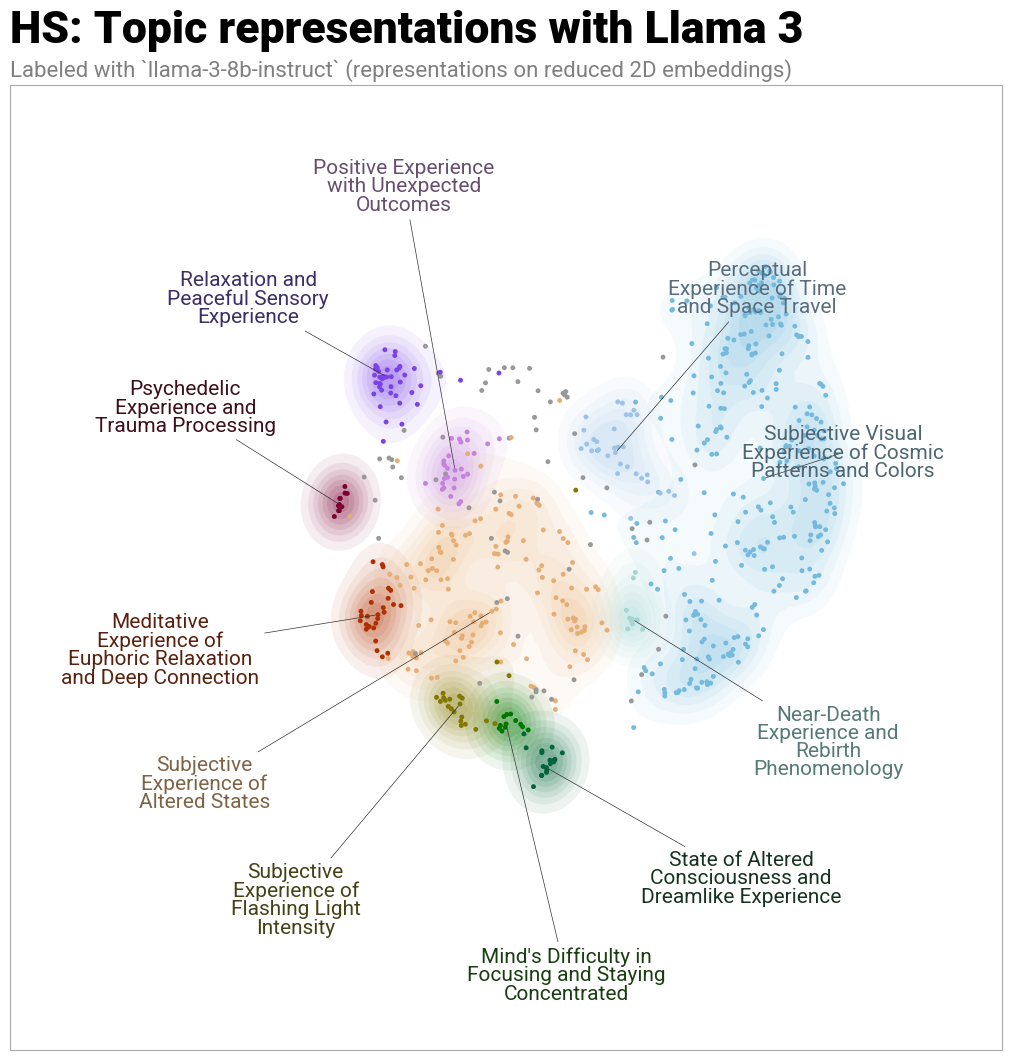

In [26]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

In [29]:
display(topic_model.visualize_hierarchy(custom_labels=True,color_threshold=.8))

### create and save final topic summary

In [ ]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}_2.csv")
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")
